# 91APP EDA

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter,FormatStrFormatter
from datetime import datetime

For this EDA, we will only load the core data, which is the orders data and the members data. Other data tables will be used when investigating deeper.

In [14]:
df_orders = pd.read_csv('Orders.csv', header = 0)
df_members = pd.read_csv('Member.csv', header = 0)

C:\Users\kharr\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\kharr\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Revenue by Date

Here we try to find the general trend of revenue earned over time.

In [39]:
revenue_trend = df_orders[['DateId', 'SalesOrderSlaveTotalPayment']].copy().groupby(['DateId'], as_index = False).sum()
revenue_trend['DateId'] = revenue_trend['DateId'].astype(str).apply(lambda x: datetime.strptime(x, '%Y%m%d'))

revenue_trend.head()

,DateId,SalesOrderSlaveTotalPayment
0,2015-05-06,5999.0
1,2015-05-07,8547.0
2,2015-05-08,14664.0
3,2015-05-09,20439.0
4,2015-05-10,22902.0


Text(0,0.5,'Revenue (NTD)')

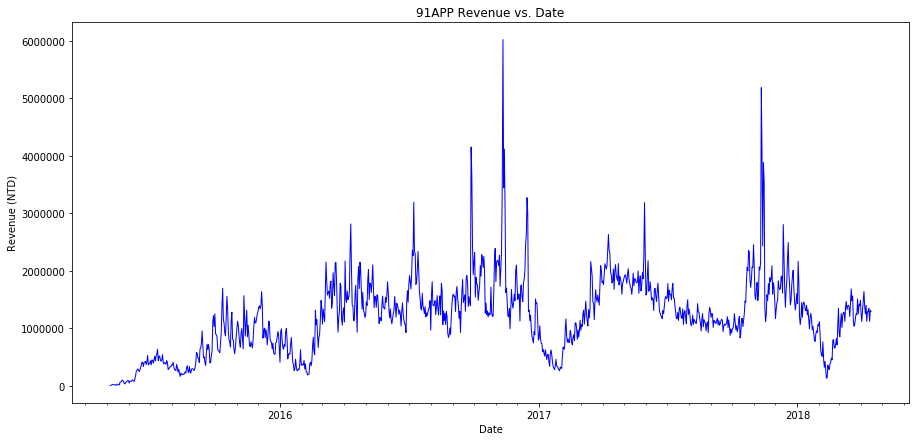

In [43]:
years = mdates.YearLocator()
months = mdates.MonthLocator()
yearsFmt = mdates.DateFormatter('%Y')

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)

ax.plot(revenue_trend['DateId'], revenue_trend['SalesOrderSlaveTotalPayment'], lw = 1, color = 'blue', alpha = 1)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)


ax.set_title('91APP Revenue vs. Date')
ax.set_xlabel('Date')
ax.set_ylabel('Revenue (NTD)')

We can see that revenue performance in 2016 and 2017 is better than in 2015, but it is hard to tell the performance between 2016 and 2017. We can try to plot comparison by month on different years.

In [56]:
revenue_ym = revenue_trend.copy()
revenue_ym['YearM'] = revenue_ym['DateId'].apply(lambda x: datetime.strftime(x, '%Y'))
revenue_ym['MonthId'] = revenue_ym['DateId'].apply(lambda x:datetime.strftime(x, '%m'))
revenue_ym = revenue_ym.groupby(['YearId', 'MonthId'], as_index = False).sum()

revenue_ym = revenue_ym.pivot(index = 'MonthId', columns = 'YearId', values = 'SalesOrderSlaveTotalPayment').reset_index()
revenue_ym['MonthId'] = revenue_ym['MonthId'].apply(lambda x:datetime.strptime(x, '%m')).apply(lambda x:datetime.strftime(x, '%b'))


revenue_ym.head()

YearId,MonthId,2015,2016,2017,2018
0,Jan,NaN,17531969.0,15660334.0,37532190.0
1,Feb,NaN,18394835.0,22964598.0,16416815.0
2,Mar,NaN,47575199.0,45108050.0,39743706.0
3,Apr,NaN,48540201.0,59067252.0,19622878.0
4,May,1088629.0,46778551.0,58892916.0,NaN


Text(0,0.5,'Revenue (NTD)')

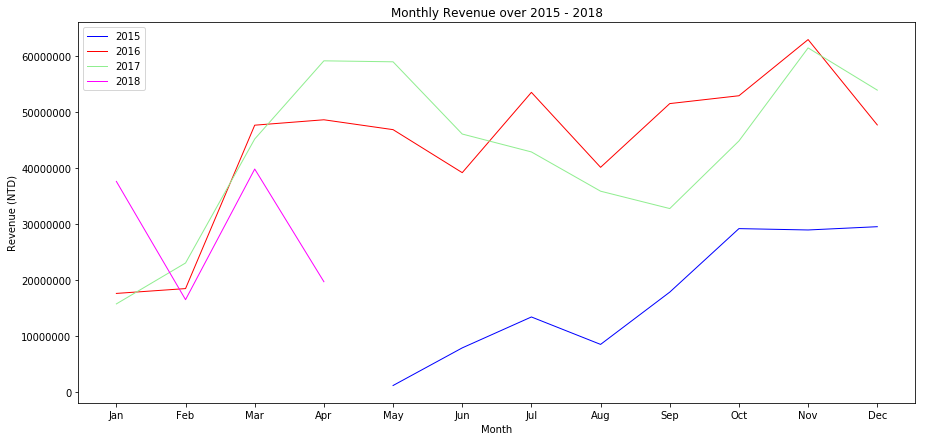

In [71]:
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(111)

ax1.plot(revenue_ym['MonthId'], revenue_ym['2015'], label = '2015', lw = 1, color = 'blue', alpha = 1)
ax1.plot(revenue_ym['MonthId'], revenue_ym['2016'], label = '2016', lw = 1, color = 'red', alpha = 1)
ax1.plot(revenue_ym['MonthId'], revenue_ym['2017'], label = '2017', lw = 1, color = 'lightgreen', alpha = 1)
ax1.plot(revenue_ym['MonthId'], revenue_ym['2018'], label = '2018', lw = 1, color = 'magenta', alpha = 1)

ax1.legend()
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax1.set_title('Monthly Revenue over 2015 - 2018')
ax1.set_xlabel('Month')
ax1.set_ylabel('Revenue (NTD)')

Here we see that 2016 performed better than 2017 in the second half of the year, while performing worse in the first half of the year.

## Member Groupings

We now want to try to group the users into 4 quartiles: Bottom 25% (Quartile 1), Third 25% (Quartile 2), Second 25% (Quartile 3) and Top 25% (Quartile 4). We also want to see how each quartile contributes to the overall revenue.

In [18]:
member_group = df_orders[['MemberId','SalesOrderSlaveTotalPayment']].groupby(['MemberId'], as_index = False).sum()
member_group['MemberGroupings'] = pd.qcut(member_group['SalesOrderSlaveTotalPayment'], 4, labels = ['Quartile 1', 'Quartile 2', 'Quartile 3', 'Quartile 4'])
member_group.head()

,MemberId,SalesOrderSlaveTotalPayment,MemberGroupings
0,1326,249.0,Quartile 1
1,1329,918.0,Quartile 2
2,1334,999.0,Quartile 2
3,1336,12473.0,Quartile 4
4,1362,591.0,Quartile 1


In [19]:
member_groupsum = member_group[['MemberGroupings', 'SalesOrderSlaveTotalPayment']].groupby(['MemberGroupings'], as_index = False).sum()
member_groupsum.head()

,MemberGroupings,SalesOrderSlaveTotalPayment
0,Quartile 1,70221623.0
1,Quartile 2,131870915.0
2,Quartile 3,247823770.0
3,Quartile 4,844309281.0


Text(0,0.5,'Total Revenue')

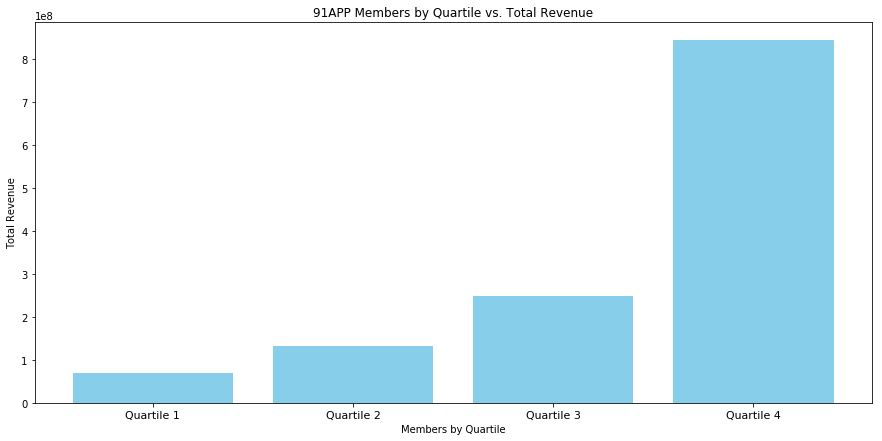

In [22]:
fig = plt.figure(figsize=(15, 7))
ax2 = fig.add_subplot(111)

for (i, row) in member_groupsum.iterrows():
    plt.bar([i], [row['SalesOrderSlaveTotalPayment']],
            color=['skyblue'], width=0.8, align='center', edgecolor='none')
    
plt.xticks(np.arange(4), member_groupsum['MemberGroupings'], fontsize = 11)
plt.title('91APP Members by Quartile vs. Total Revenue')
plt.xlabel('Members by Quartile')
plt.ylabel('Total Revenue')
    

From the graph we see that Quartile 1 members only contribute less than 100 million NTD to the total revenue, while Quartile 4 members contribute up to 800 million NTD to the total revenue.

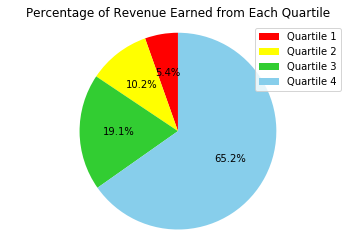

In [52]:
labels = df3['MemberGroupings']
sizes = df3['SalesOrderSlaveTotalPayment']

fig1, ax1 = plt.subplots()
patches, texts, autotexts = ax1.pie(sizes, colors = ['red','yellow','limegreen','skyblue'], autopct='%1.1f%%', startangle = 90)

ax1.legend(patches, labels, loc = 'best')
ax1.axis('equal')
ax1.set_title('Percentage of Revenue Earned from Each Quartile')
plt.show()

For the entire time period (May 2015 - Apr 2018), Quartile 4 members make up for 65.2% of the total revenue earned, while Quartile 1 members only make up for 5.4% of the total revenue.